# <center> Logistic Regression </center>

In this lab we'll see how to use scikit-learn's logistic regression function. We'll apply this to two classes from the first data competition dataset and run the code on AWS. After this lab, you should know:
- How to fit a logistic regression model with scikit-learn
- How to run an iPython notebook on AWS

## 0 Data Competition
The first data competition is now live! You can sign up by going to this link:
https://www.kaggle.com/t/67e21f107b1845168ef84ce90b0f0716
All of the instructions are on the data competition website.

## 1 Logistic Regression 
Recall that in logistic regression we have a binary response variable $y$ and use the model
$$ P(y=1|X; \beta) = \frac{\exp{(\beta_0+\beta_1X_1 + \cdots + \beta_dX_d)}}{1+\exp{(\beta_0+\beta_1X_1 + \cdots + \beta_dX_d)}}.$$
By transforming the linear combination of predictors, $\beta_0 + \beta_1X_1 + \cdots + \beta_dX_d$, in the above equation we ensure that $P(y=1|X;\beta)$ (the estimated probability that the response is equal to 1, conditional on the predictors $X=(X_1,\dots,X_d)$) is always between 0 and 1. 
We can also rearrange the above equation to get
$$ \log\left(\frac{P(y=1|X; \beta)}{1-P(y=1|X; \beta)}\right) = \beta_0 + \beta_1X_1 + \cdots + \beta_dX_d.$$

** Exercise 1 ** Consider data $(y_i,x_i)$ for $i=1,\dots, n$, where $y_i\in\{0,1\}$, $x_i = (x_{i1},\dots, x_{ip})^T$ for $i=1,\dots n$, and an intercept is included in the $x_i$'s.  Show that maximizing the log-likelihood in this case entails solving the problem
$$\min_{\beta \in \mathbb{R}^d} \: -\frac{1}{n} \sum_{i=1}^n \left(y_i\beta^Tx_i- \log(1+\exp(x_i^T \beta))\right).$$

** Exercise 2 ** Suppose in the above exercise the labels are in the set $\{-1, +1\}$ instead of $\{0, 1\}$. Show that maximizing the log-likelihood in this case entails solving the problem 
$$\min_{\beta \in \mathbb{R}^d} \: \frac{1}{n} \sum_{i=1}^n \log\left(1+ \exp(-y_i \,x_i^T \beta)\right).$$

After fitting the model we often label a new input $x$ with 1 if our estimated probability of it being 1, $P(y=1|x; \beta^\star)$, is larger than the estimated probability of it being zero, $P(y=-1|x;\beta^\star)$ (or 0, depending on the convention). 

** Exercise 3 ** Denote by $\beta^\star=(\beta_0^\star, \dots, \beta_p^\star)$ the $\beta$ that maximizes the log-likelihood. Show that $P(y=1|x;\beta^\star)>P(y=-1|x;\beta^\star)$ if and only if $(\beta^\star)^T x > 0,$ where $x$ is assumed to include the intercept.

### 1.1 Log sum exp trick
In practice, $\exp(x_i^T\beta)$ could be very large or very close to zero, resulting in overflow or underflow. Suppose we want to compute $\log(1+\exp(1000))$:

In [1]:
import numpy as np
np.log(1+np.exp(1000))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


inf

It appears as though we get an overflow error! But it should be finite, since $1+\exp(1000)\approx \exp(1000)$ and hence $\log(1+\exp(1000)) \approx \log(\exp(1000)) = 1000$. To circumvent this problem, people use a trick: the fact that
$$ \log(1+\exp(x)) = a + \log(\exp(-a) + \exp(x-a))$$
for any $a$.

** Exercise 4* ** Show that the above identity is true.

** Exercise 5 ** Use the above identity to compute $\log(1+\exp(1000))$.

In [2]:
# Let's choose a = 1000.
a = 1000
x = a
a + np.log(np.exp(-a)+np.exp(x-a))

1000.0

You should get something close to 1000.

### 1.2 Loading the data
Starting this week you will be working on the data competition as part of your homework. I have turned images from two of the classes (Hornbill and Pelican) into features that we'll use in this lab. You can download this data from Canvas.

** To do: ** Change the directory below (if necessary) to load in the data for this lab.

In [3]:
import numpy as np
import os

data_dir = 'lab3_data'

x_train = np.load(os.path.join(data_dir, 'train_features.npy'))
y_train = np.load(os.path.join(data_dir, 'train_labels.npy'))
x_test = np.load(os.path.join(data_dir, 'val_features.npy'))
y_test = np.load(os.path.join(data_dir, 'val_labels.npy'))

"Hornbill" has label 0 and "Toucan" has label 1. There are 500 images in the training set and 100 images in the validation set. I'm not providing you the labels to the test set, so we'll consider the validation set to be the test set here. There is one *row* for each image.

In [4]:
print('Number of images:', x_train.shape[0])
print('Dimension of features:', x_train.shape[1])

Number of images: 1000
Dimension of features: 4096


### 1.3 Classification using Scikit-Learn
Here we're going to use logistic regression from Scikit-learn to classify the images. 

** Exercise 6 ** Standardize the data. You may use Scikit-learn's `StandardScaler` for this. Use the same names for the normalized data (`x_train` and `x_test`).  
Reference: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

As with linear regression, when using logistic regression it is beneficial to add a penalty term on the norm of the weights. With this penalty, we then optimize the expression
$$\min_{\beta \in \mathbb{R}^d}\; \frac{1}{n} \sum_{i=1}^n \log\left(1+ \exp(-y_i \,x_i^T \beta)\right) + \lambda \|\beta\|^2_2.$$
(where the labels are $\pm 1$). We choose $\lambda$ via cross-validation.

** Exercise 7 ** Use `LogisticRegressionCV` to fit the model to the training data. For today use the default parameter values. Then compute the accuracy on the test set. Use `classifier` as the name of your instantiation of `LogisticRegressionCV`.
Reference: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html  

In [6]:
from sklearn.linear_model import LogisticRegressionCV
classifier = LogisticRegressionCV()
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.88

We're able to get 88% accuracy! Let's get an idea of what images it classified correctly and incorrectly.

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def display_ranked_image_list(names, image_dir, scores, num_images=10, cutoff=0.5, true_labels=None, display_mistakes=False):
    """
    Display a (subset of a) ranked list of images. By default, this function displays
    10 images from the list of image names ("names") sorted by decreasing scores ("scores").
    :param names: List of image names
    :param scores: Scores for each image (from some classifier)
    :param num_images: Number of images to display
    :param true_labels: The true labels of each image
    :param display_mistakes: Whether to only display the top images on which the classifier made mistakes
    """
    ncol = 6
    
    idxs = np.argsort(scores)
    if not display_mistakes:
        idxs = idxs[-num_images:]
    else:
        mistakes = np.where(true_labels != 1)[0]
        idxs = [i for i in idxs if (i in mistakes and scores[i] > cutoff)][-num_images:]
    
    num_images = len(idxs)
    nrow = int(num_images/6) + 1 if num_images % 6 != 0 else int(num_images/6)
    fig = plt.figure()
    fig.set_figwidth(15)
    fig.set_figheight(5*nrow/2)
    for i in range(1, num_images+1):
        idx = idxs[i-1]
        a = fig.add_subplot(nrow, 6, num_images-i+1)
        img = mpimg.imread(os.path.join(image_dir, names[idx]))
        imgplot = plt.imshow(img)
        a.set_title(scores[idx])
        plt.axis('off')
    plt.show()

Images it was most confident were toucans that were in fact toucans:


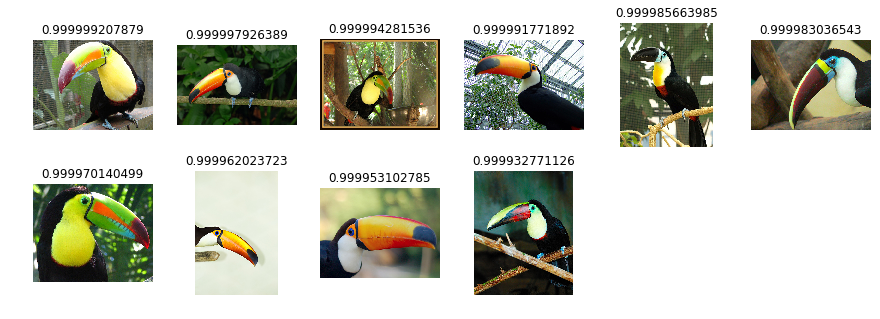

Images it was most confident about being toucans that were not toucans:


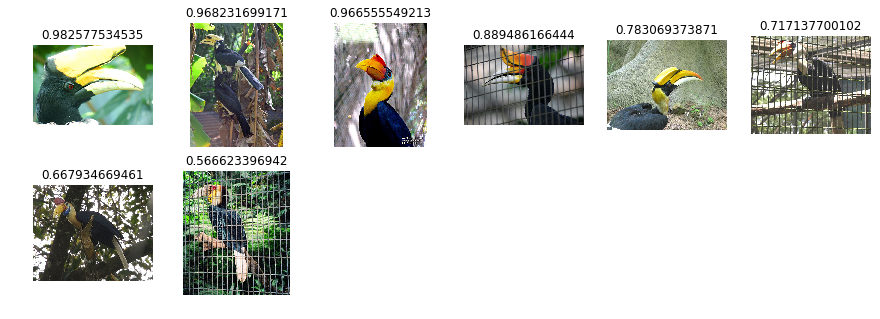

Images it was most confident were hornbills that were in fact hornbills:


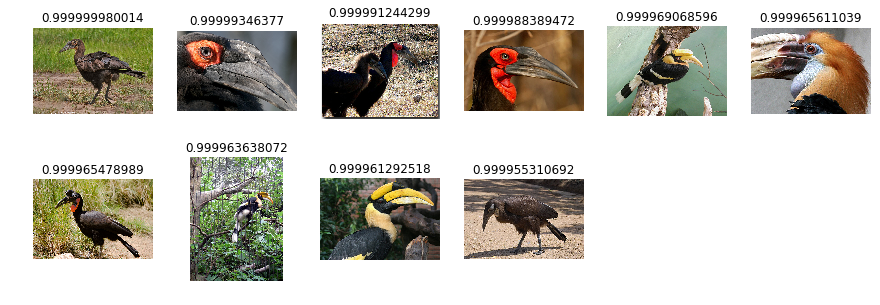

Images it was most confident about being hornbills that were not hornbills:


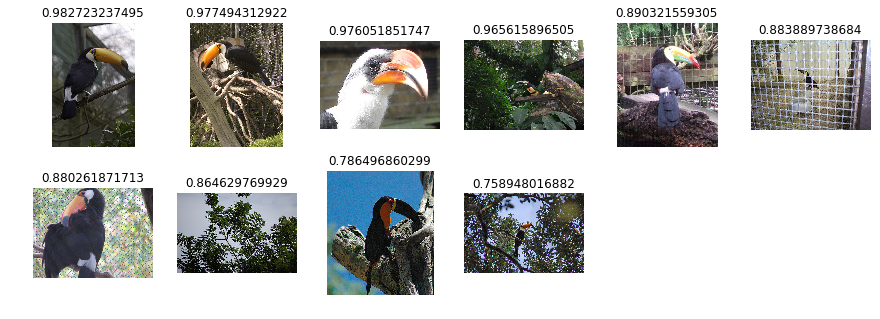

In [8]:
# Get names of files in validation set
image_names = sorted(os.listdir(os.path.join(data_dir, 'images', 'val')))
image_dir = os.path.join(data_dir, 'images', 'val')

# Generate estimated values for test observations using the logistic regression classifier
test_probs = classifier.predict_proba(x_test)

# See the images it was most confident were toucans that were in fact toucans
print('Images it was most confident were toucans that were in fact toucans:')
display_ranked_image_list(image_names, image_dir, test_probs[:, 1])

#  See the images it was most confident about being toucans that were not toucans
print('Images it was most confident about being toucans that were not toucans:')
display_ranked_image_list(image_names, image_dir, test_probs[:, 1], true_labels=y_test, display_mistakes=True)

# See the images it was most confident were hornbills
print('Images it was most confident were hornbills that were in fact hornbills:')
display_ranked_image_list(image_names, image_dir, 1-test_probs[:, 1])

#  See the images it was most confident about being hornbills that were not hornbills
print('Images it was most confident about being hornbills that were not hornbills:')
display_ranked_image_list(image_names, image_dir, 1-test_probs[:, 1], true_labels=(y_test-1)*-1, display_mistakes=True)


Up until now we've only discussed accuracy as a way of measuring the quality of a classifier. However, it turns out that there are also other ways to do so. We'll see these in a future lab.

## 3 Running iPython notebooks on AWS

Running this iPython notebook on AWS can be done by following the steps below:
1. Create an AWS instance as in the AWS tutorial. 
2. Upload the relevant files to your AWS instance via sftp or scp.
3. Follow the instructions here: https://coderwall.com/p/ohk6cg/remote-access-to-ipython-notebooks-via-ssh

Hints:
- Instead of `remote_user@remote_host`, substitute the information AWS gives you that is of the form `-i "key.pem" ubuntu@ec2-107-20-0-21.compute-1.amazonaws.com`.
- If when you go to `localhost:8888` it says something about a password then copy the URL that was displayed when you ran `ipython notebook --no-browser --port=8889` into your browser instead and change the port to `8888` (the one you specified for your machine).
- If it says a port you specified isn't available, then change `8888` and/or `8889`.
- You should activate one of the conda environments as it says when you log onto the instance. Then to get this code to run you may need to pip install scipy and scikit-learn.